In [6]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import time
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.
Input Gate: conditionally decides which values from the input to update the memory state.
Output Gate: conditionally decides what to output based on input and the memory of the block.# LSTM Network

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN). A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: These are independent observations from the domain, typically rows of data.
Time steps: These are separate time steps of a given variable for a given observation.
Features: These are separate measures observed at the time of observation.
We have some flexibility in how the dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

<img src="./images/LSTM_1.png" alt="drawing" width="800"/>
<img src="./images/LSTM_2.png" alt="drawing" width="800"/>
<img src="./images/LSTM_3.png" alt="drawing" width="800"/>
<img src="./images/LSTM_4.png" alt="drawing" width="800"/>

There are three types of gates within a unit:
- Forget Gate: conditionally decides what information to throw away from the block.
- Input Gate: conditionally decides which values from the input to update the memory state.
- Output Gate: conditionally decides what to output based on input and the memory of the block.

# LSTM for Regression

In [7]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [8]:
# load the dataset
dataframe = pandas.read_csv('./data/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             


Text(0, 0.5, 'Monthly total of passangers (x10e3)')

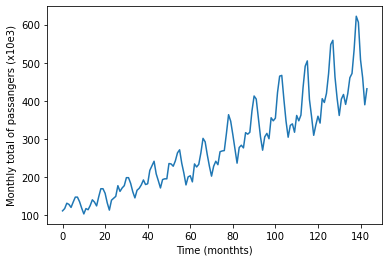

In [9]:
# Inspect the dataset
print(dataframe.head())
plt.plot(dataset)
plt.xlabel('Time (monthts)')
plt.ylabel('Monthly total of passangers (x10e3)')

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
print('len(dataset): ',len(dataset))
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

len(dataset):  144
96 48


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [37]:
# reshape into X=t and Y=t+1
look_back = 1
# our data is in the form: [samples, features]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# Reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5,:,:].flatten())
print('trainY[:5]: ', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # hidden layer with 4 LSTM blocks or neurons
model.add(Dense(1)) # output layer that makes a single value prediction

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (94, 1, 1)
trainY.shape:  (94,)
trainX[:5]:  [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853]
trainY[:5]:  [0.02702703 0.05405405 0.04826255 0.03281853 0.05984557]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 19.30563449859619 seconds ---


In [38]:
# summarize history for loss
def plot_hist(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

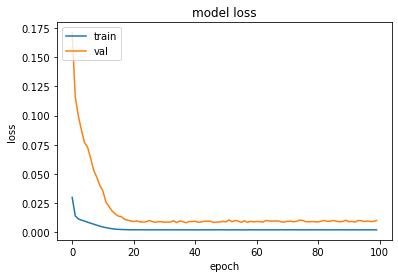

In [39]:
plot_hist(history)

In [40]:
# make predictions
def make_preds(trainX,trainY,testX,testY):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))
    
    return trainPredict, testPredict

In [41]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

Train Score: 22.89 RMSE
Train R^2:  0.8957572193638053
Test Score: 51.87 RMSE
Test R^2:  0.5570538176644306


In [42]:
# shift train predictions for plotting
def plot_preds(trainPredict,testPredict):
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

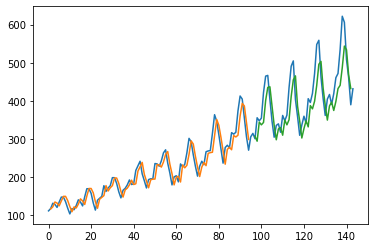

In [43]:
plot_preds(trainPredict,testPredict)

In [18]:
## Redo using SGD as optimizer 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.SGD(learning_rate=0.01))

# Fit the model
history = model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 49.30418014526367 seconds ---


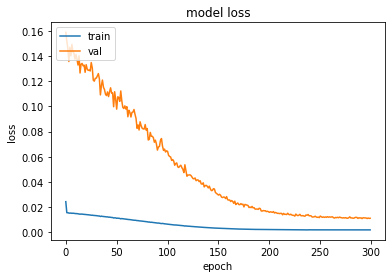

In [19]:
plot_hist(history)

In [20]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

Train Score: 22.60 RMSE
Train R^2:  0.898347179295521
Test Score: 54.78 RMSE
Test R^2:  0.5059294041383154


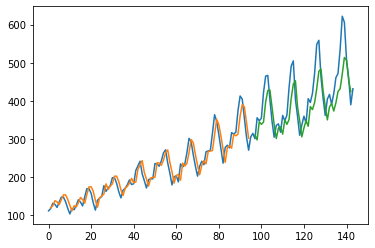

In [21]:
plot_preds(trainPredict,testPredict)

### Question: Now that you are an expert in Neural Nets design, what else would you change in this model in order to make it better? 
Look at the configs used by the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/)

# LSTM for Regression Using the Window Method

We have been using a single feauture/time step to perform prediction. What if we use more samples to perform the prediction? 

Let's see what happens...

In [50]:
# reshape into X=t and Y=t+3
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

trainX.shape:  (92, 3)
trainY.shape:  (92,)
trainX[:5]: 
 [[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]


In [51]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]: 
 [[[0.01544401 0.02702703 0.05405405]]

 [[0.02702703 0.05405405 0.04826255]]

 [[0.05405405 0.04826255 0.03281853]]

 [[0.04826255 0.03281853 0.05984557]]

 [[0.03281853 0.05984557 0.08494207]]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 18.193872213363647 seconds ---


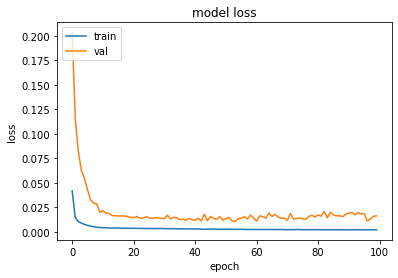

In [52]:
plot_hist(history)

In [53]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

Train Score: 22.18 RMSE
Train R^2:  0.9007666093243802
Test Score: 65.93 RMSE
Test R^2:  0.27055594832977514


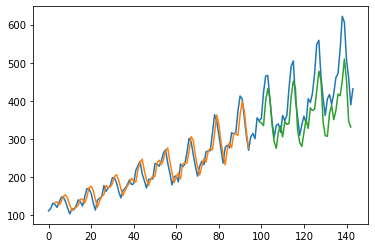

In [54]:
plot_preds(trainPredict,testPredict)

### Question: Compare the performance obtained on single points versus the window method. What are the advantages of one versus the other?

# LSTM for Regression with Time Steps

Now we will reformulate the problem: instead of dealing with the past observations as independent features, we will consider them as time steps of one input feature. 

In [61]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (92, 3, 1)
trainY.shape:  (92,)
trainX[:5]: 
 [[[0.01544401]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]]]
trainY[:5]: 
 [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 25.08366847038269 seconds ---


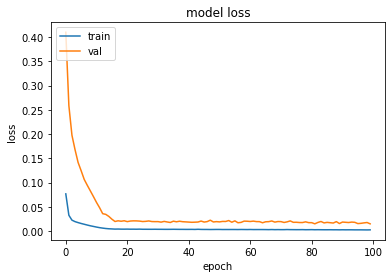

In [62]:
plot_hist(history)

In [63]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

Train Score: 26.67 RMSE
Train R^2:  0.8566181164131349
Test Score: 63.53 RMSE
Test R^2:  0.32260576619052406


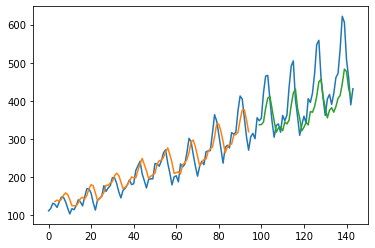

In [64]:
plot_preds(trainPredict,testPredict)

# LSTM with Memory Between Batches

In order to prevent the LSTM to find dependencies between your batches, it is set to be "stateless" by default. But what if the dependency between the batches is somehow informative for LSTM to learn? Let's see what happens when we let the LSTM to build state over the entire training sequence.

In [76]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False, validation_data=(testX, testY))
	model.reset_states()
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

Deleting "model"
92/92 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0119
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 32.09107232093811 seconds ---


In [77]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

Train Score: 26.17 RMSE
Train R^2:  0.8618876322615469
Test Score: 57.94 RMSE
Test R^2:  0.4366829761048209


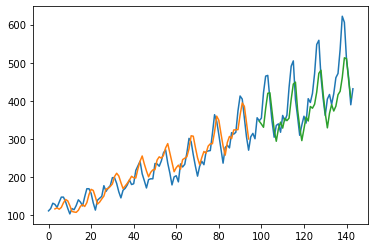

In [78]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Stacked LSTMs with Memory Between Batches

Let's see what happens with we use a deeper LSTM network

In [81]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(500):
    print('Epoch: ',i)
	history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False, validation_data=(testX, testY))
	model.reset_states()
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

Deleting "model"
92/92 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0098
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 231.93316960334778 seconds ---


Train Score: 20.20 RMSE
Train R^2:  0.9177000202938888
Test Score: 51.63 RMSE
Test R^2:  0.552675924972627


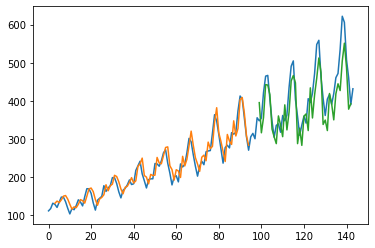

In [82]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [19]:
# Let's see what happens if we let it train for longer
# Using Early stopping 

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
batch_size = 1

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=5000, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))


trainX.shape:  (92, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544401 0.02702703 0.05405405 0.02702703 0.05405405 0.04826255
 0.05405405 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494207]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 1270.342755317688 seconds ---


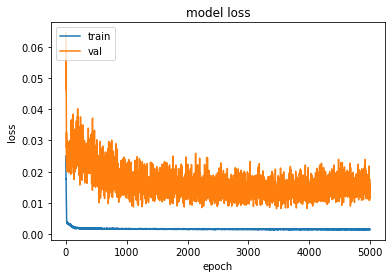

In [20]:
plot_hist(history)

Train Score: 19.86 RMSE
Train R^2:  0.9204386837643034
Test Score: 55.34 RMSE
Test R^2:  0.4861151611222846


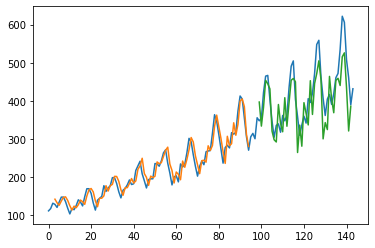

In [21]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Adding Early Stopping

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [28]:
# Using Early stopping 
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=1, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544401 0.02702703 0.05405405 0.02702703 0.05405405 0.04826255
 0.05405405 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494207]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"
Epoch 1/1000
74/92 [=======================>......] - ETA: 0s - loss: 0.0229
Epoch 00001: val_loss improved from inf to 0.14344, saving model to ./models/best_model_LSTM.h5
92/92 [==============================] - 1s 15ms/step - loss: 0.0229 - val_loss: 0.1434
Epoch 2/1000
77/92 [========================>.....] - ETA: 0s - loss: 0.0187
Epoch 00002: val_loss improved from 0.14344 to 0.12947, saving model to ./models/best_model_LSTM.h5
92/92 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.1295
Epoch 3/1000
92/92 [==============================] - ETA: 0s - loss: 0.0187
Epoch 00003: val_loss improved from 0.12947 to 0.11911, saving model to ./models/b

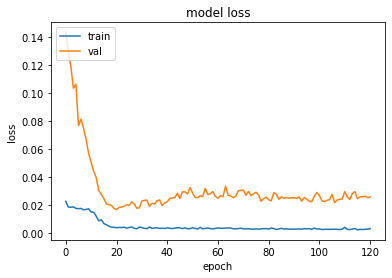

In [29]:
plot_hist(history)

Train Score: 39.41 RMSE
Train R^2:  0.6867801999922779
Test Score: 69.46 RMSE
Test R^2:  0.19033586056608032


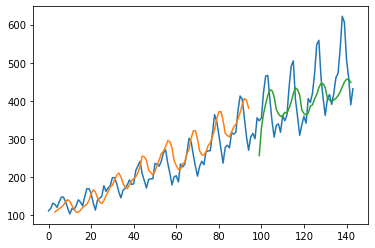

In [30]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544401 0.02702703 0.05405405 0.02702703 0.05405405 0.04826255
 0.05405405 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494207]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"

Epoch 00001: val_loss improved from inf to 0.12559, saving model to ./models/best_model_LSTM.h5

Epoch 00002: val_loss did not improve from 0.12559

Epoch 00003: val_loss improved from 0.12559 to 0.08398, saving model to ./models/best_model_LSTM.h5

Epoch 00004: val_loss improved from 0.08398 to 0.06626, saving model to ./models/best_model_LSTM.h5

Epoch 00005: val_loss improved from 0.06626 to 0.03226, saving model to ./models/best_model_LSTM.h5

Epoch 00006: val_loss improved from 0.03226 to 0.02353, saving model to ./models/best_model_LSTM.h5

Epoch 00007: val_loss improved from 0.02353 to 0.02047, saving model to ./models/best_model_LSTM.h5

Epoch 00008: val_loss improve

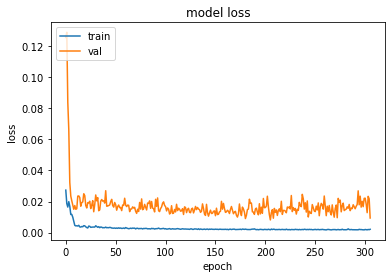

Train Score: 30.20 RMSE
Train R^2:  0.8161264474230372
Test Score: 46.70 RMSE
Test R^2:  0.634043197857268


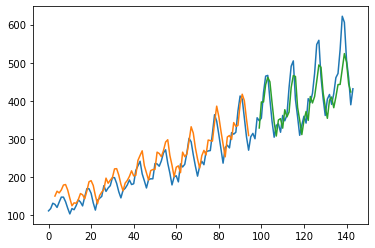

In [32]:
# Try more nodes in the LSTM
# Using Early stopping 

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(9, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=0, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

plot_hist(history)

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

trainX.shape:  (92, 1, 3)
trainY.shape:  (92,)
trainX[:5]:  [0.01544401 0.02702703 0.05405405 0.02702703 0.05405405 0.04826255
 0.05405405 0.04826255 0.03281853 0.04826255 0.03281853 0.05984557
 0.03281853 0.05984557 0.08494207]
trainY[:5]:  [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
Deleting "model"

Epoch 00001: val_loss improved from inf to 0.10907, saving model to ./models/best_model_LSTM.h5

Epoch 00002: val_loss did not improve from 0.10907

Epoch 00003: val_loss did not improve from 0.10907

Epoch 00004: val_loss did not improve from 0.10907

Epoch 00005: val_loss did not improve from 0.10907

Epoch 00006: val_loss did not improve from 0.10907

Epoch 00007: val_loss improved from 0.10907 to 0.09449, saving model to ./models/best_model_LSTM.h5

Epoch 00008: val_loss improved from 0.09449 to 0.08627, saving model to ./models/best_model_LSTM.h5

Epoch 00009: val_loss improved from 0.08627 to 0.05051, saving model to ./models/best_model_LSTM.h5

Epoch 00010: val_loss i

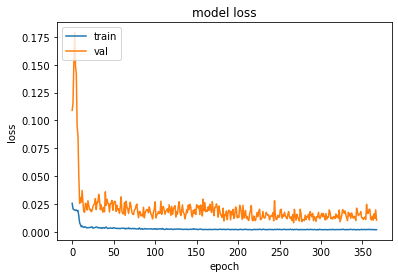

Train Score: 27.09 RMSE
Train R^2:  0.851983121848121
Test Score: 46.38 RMSE
Test R^2:  0.6389504345631305


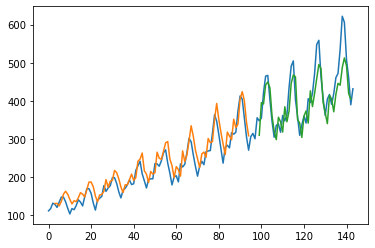

In [34]:
# More layers
# Try more nodes in the LSTM
# Using Early stopping 

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(8, batch_input_shape=(batch_size, 1,look_back), stateful=True,return_sequences=True))
model.add(LSTM(8, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=0, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

plot_hist(history)

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size 
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()